In [7]:
%matplotlib inline

In [8]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import seaborn
import cv2

from PIL import Image

# Data

generate plots with corresponding masks

In [336]:
class PlotDataset(Dataset):
    def __init__(self, num_samples, transform=None, tolerance=5):
        self.num_samples = num_samples
        self.transform = transform
        self.tolerance = tolerance

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Generate random coefficients
        a1, a2 = np.random.uniform(-10, 10, 2)
        a3, a4, a5 = np.random.uniform(-1, 1, 3)
        
        # Generate x values
        x = np.linspace(-10, 10, 100)
        
        # Generate y values for linear and parabolic functions
        y_linear = a1 * x + a2
        y_parabolic = a3 * x**2 + a4 * x + a5
        
        # Create figure
        fig, ax = plt.subplots(figsize=(32, 32))
        ax.set_xlim(-10, 10)
        ax.set_ylim(-100, 100)
        
        # Plot the linear function
        line_color = np.random.rand(3,)
        ax.plot(x, y_linear, color=line_color)
        
        # Plot the parabolic function
        parab_color = np.random.rand(3,)
        ax.plot(x, y_parabolic, color=parab_color)
        
        # Save plot as image
        fig.canvas.draw()
        image = np.array(fig.canvas.renderer.buffer_rgba())
        plt.close(fig)
        
        # Convert RGBA to RGB
        image = image[:, :, :3]
        
        # Create mask
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        
        # Draw axes on mask (Assuming axes are black lines)
        mask[image[:, :, 0] == 0] = 1
        
        # Define a helper function for color matching with tolerance
        def within_tolerance(img, color, tol):
            return np.all(np.abs(img - np.array(color) * 255) <= tol, axis=-1)
        
        # Add linear function to mask
        mask[within_tolerance(image, line_color, self.tolerance)] = 2
        
        # Add parabolic function to mask
        mask[within_tolerance(image, parab_color, self.tolerance)] = 3
        
        # Apply transformations to image
        if self.transform:
            image = self.transform(image)
        
        # Convert mask to tensor manually to avoid scaling
        mask = torch.tensor(mask, dtype=torch.long)
        
        return image, mask

# Define transformations for the image
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create dataset and dataloader
dataset = PlotDataset(num_samples=1000, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [337]:
# Example usage
for images, masks in dataloader:
    print(images.shape, masks.shape)
    break

fig, axes = plt.subplots(4, 6, figsize=(9, 5))
axes = axes.ravel()

for i in range(6):
    axes[i].imshow(images[i].permute(1,2,0))
    axes[i].axis("off")
    axes[i+6].imshow(masks[i])
    axes[i+6].axis("off")
    axes[i + 6].set_title(f"{np.unique(masks[i])}")

for i in range(6):
    axes[i + 12].imshow(images[i + 6].permute(1,2,0))
    axes[i + 12].axis("off")
    axes[i + 18].imshow(masks[i + 6])
    axes[i + 18].axis("off")
    axes[i + 18].set_title(f"{np.unique(masks[i + 6])}")

plt.tight_layout()
plt.show()

torch.Size([32, 3, 3200, 3200]) torch.Size([32, 3200, 3200])


/var/folders/yt/vsz4v53j4bv674jbw4t304p80000gn/T/ipykernel_22286/3856567545.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


# Unet

In [224]:
from torch.functional import F
from torch import nn
from torchinfo import summary

CONV_KERNEL = (3, 3)
POOL_KERNEL = (2, 2)
STRIDE_SIZE = (1, 1)
PADDING_TYPE = 1

class DownBlock(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels, **kwargs):
        super(DownBlock, self).__init__(**kwargs)

        self.conv_1 = nn.Conv2d(in_channels=in_channels,
                                out_channels=out_channels,
                                kernel_size=CONV_KERNEL,
                                padding=PADDING_TYPE)
        self.conv_2 = nn.Conv2d(in_channels=out_channels,
                                out_channels=out_channels,
                                kernel_size=CONV_KERNEL,
                                padding=PADDING_TYPE)
        self.batch_1 = nn.BatchNorm2d(num_features=out_channels)
        self.batch_2 = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=POOL_KERNEL)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.relu(x)
        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x

def UpperBlockCustom(ConvTranspose, in_channels, out_channels):
    class UpperBlock(nn.Module):
        def __init__(self, in_channels: int, out_channels: int, **kwargs):
            super(UpperBlock, self).__init__(**kwargs)
            self.convT = ConvTranspose(in_channels=in_channels,
                                       out_channels=out_channels,
                                       kernel_size=CONV_KERNEL,
                                       stride=STRIDE_SIZE,
                                       padding=PADDING_TYPE)

        def forward(self, x, w=None):
            if w is not None:
                x = self.convT(x, w)
            else:
                x = self.convT(x)
            s = x.shape[2:]
            x = F.interpolate(x,
                              size=(s[0] * 2, s[1] * 2),
                              mode='bilinear',
                              align_corners=False)
            return x

    return UpperBlock(in_channels, out_channels)

n = 6
class UNet(nn.Module):

    def __init__(self, depth: int = 3, **kwargs):
        super(UNet, self).__init__(**kwargs)
        self.depth = depth
        self.down_blocks = nn.ModuleDict()
        self.down_blocks[str(0)] = DownBlock(in_channels=1,
                                        out_channels=64)
        n_feat = 64
        for i in range(1, depth):
            self.down_blocks[str(i)] = DownBlock(in_channels=n_feat,
                                            out_channels=2 * n_feat)
            n_feat *= 2

        self.up_block = nn.ModuleDict()
        self.up_block[str(0)] = UpperBlockCustom(nn.ConvTranspose2d,
                                            64, 1)
        n_feat = 64 * (2 ** (depth - 1)) // 2
        for i in range(1, depth):
            self.up_block[str(depth-i)] = UpperBlockCustom(nn.ConvTranspose2d,
                                                  2 * n_feat, n_feat)
            n_feat //= 2

    def forward(self, x):
        x = self.down_blocks[str(0)](x)
        for i in range(1, self.depth):
            x = self.down_blocks[str(i)](x)
        for i in range(1, self.depth):
            x = self.up_block[str(self.depth - i)](x)
        x = self.up_block[str(0)](x)
        return x

model = UNet(depth=3)
summary(model, input_size=(1, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 128, 128]          --
├─ModuleDict: 1-1                        --                        --
│    └─DownBlock: 2-1                    [1, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                  [1, 64, 128, 128]         640
│    │    └─BatchNorm2d: 3-2             [1, 64, 128, 128]         128
│    │    └─ReLU: 3-3                    [1, 64, 128, 128]         --
│    │    └─Conv2d: 3-4                  [1, 64, 128, 128]         36,928
│    │    └─BatchNorm2d: 3-5             [1, 64, 128, 128]         128
│    │    └─ReLU: 3-6                    [1, 64, 128, 128]         --
│    │    └─MaxPool2d: 3-7               [1, 64, 64, 64]           --
│    └─DownBlock: 2-2                    [1, 128, 32, 32]          --
│    │    └─Conv2d: 3-8                  [1, 128, 64, 64]          73,856
│    │    └─BatchNorm2d: 3-9             [1, 128, 64, 64]          256
│  

In [233]:
target = torch.randint(0, 2, (32, 128, 128))
target.shape

torch.Size([32, 128, 128])

In [255]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the Dice Loss for multi-class segmentation
class DiceLoss(nn.Module):
    def __init__(self, num_classes, smooth=1):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, logits, targets):
        # Apply softmax to get probabilities
        logits = F.softmax(logits, dim=1)
        
        # One-hot encode the targets
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).permute(0, 3, 1, 2).float()
        
        # Compute Dice loss
        intersection = (logits * targets_one_hot).sum(dim=(2, 3))
        union = logits.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        
        return 1 - dice.mean()

# Define the Combined Loss function
class CombinedLoss(nn.Module):
    def __init__(self, num_classes, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss(num_classes)
        self.ce_loss = nn.CrossEntropyLoss()
        self.alpha = alpha

    def forward(self, logits, targets):
        dice = self.dice_loss(logits, targets)
        ce = self.ce_loss(logits, targets)
        return self.alpha * ce + (1 - self.alpha) * dice

# Dummy model output and target for demonstration
num_classes = 4  # For example, background, axes, linear plot, parabolic plot
output = torch.randn(32, num_classes, 128, 128)  # Model output logits
target = torch.randint(0, num_classes, (32, 128, 128))  # Ground truth mask

# Ensure target is a LongTensor containing class indices
target = target.long()

# Initialize the combined loss function
criterion = CombinedLoss(num_classes)

# Compute the loss
loss = criterion(output, target)
print(f"Loss: {loss.item()}")

Loss: 1.2364288568496704


# Test

In [261]:
from models_zoo.unet import UNet
from data.data import create_dataloader
from utils import plot_hystory, parse_arguments, count_torch_parameters

In [262]:
BATCH_SIZE = 4
IMG_SIZE = 128

In [263]:
test_dataloader = create_dataloader(num_samples=32, batch_size=BATCH_SIZE, shuffle=False, img_size=IMG_SIZE)

model = UNet()
summary(model, input_size=(1, 3, 128, 128))
count_torch_parameters(model)

Trainable parameters: 1703139
Non-trainable parameters: 0
Trainable weights (Mb): 6.812556
Non-trainable weights (Mb): 0.0


In [310]:
for X, mask in test_dataloader:
    pred = model(X)
    break

pred.shape, mask.shape

(torch.Size([4, 3, 128, 128]), torch.Size([4, 128, 128]))

# npy images

In [370]:
X = torch.randn(1, 1, 128, 128)
X = X.squeeze(dim=1)
X.shape


torch.Size([1, 128, 128])

In [363]:
for i in range(128):
    img = np.load(f'./data/train/image/{i}.npy')
    mask = np.load(f'./data/train/mask/{i}.npy')

    fig, axes = plt.subplots(1, 2, figsize=(9, 5))
    axes[0].imshow(np.transpose(img, (1,2,0)))
    axes[1].imshow(mask)
    axes[1].set_title(np.unique(mask))
    plt.savefig(f"./data/test_dataset/{i}.png")
    plt.close(fig)

In [362]:
i = 0
img = np.load(f'./data/train/image/{i}.npy')
mask = np.load(f'./data/train/mask/{i}.npy')
_, thresh = cv2.threshold(img, 0.7, 1, cv2.THRESH_BINARY)
print("---->", np.unique(thresh))

fig, axes = plt.subplots(1, 3, figsize=(9, 5))
axes[0].imshow(np.transpose(img, (1,2,0)))
axes[1].imshow(np.transpose(thresh, (1,2,0)))
axes[2].imshow(mask)
axes[2].set_title(np.unique(mask))

----> [0. 1.]


Text(0.5, 1.0, '[0 1 2]')

# TestModel

In [30]:
import torch
from torch import nn
import torch.nn.functional as F
from models_zoo.unet import UNet
from metrics.losses import DiceLoss
from torch import nn
from data.data import create_dataloader
from metrics.losses import CombinedLoss
import cv2
from data import data
import numpy as np
import tqdm
from train.train import Trainer
from utils import read_run_description, load_model
import matplotlib.pylab as plt
import mlflow  # type: ignore
import mlflow.pytorch  # type: ignore

from torch.utils.data import Dataset, DataLoader

In [318]:
def test_step(loss_fn,
              dataloader):
    model.eval()
    step_loss = 0
    n = 0
    for X, masks in dataloader:
        X = X.type(torch.float32)
        masks = masks.type(torch.float32)
        X = X
        masks = masks
        pred = model(X)
        loss = loss_fn(pred, masks)
        step_loss += loss.item()
        n += 1
    print("Loss per test: ", step_loss / n)
    pred = pred.cpu()
    masks = masks.cpu()
    masks = masks.numpy()
    pred = torch.squeeze(pred, dim=-1)
    pred = pred.detach().numpy()
    _, axes = plt.subplots(4, 6, figsize=(10, 8))
    axes = axes.ravel()
    for i in range(6):
        axes[i + 0 * 6].imshow(pred[i][0])
        axes[i + 0 *6].axis("off")
        axes[i + 1 * 6].imshow(masks[i][0, :, :])
        axes[i + 1 * 6].axis("off")
        axes[i + 2 * 6].imshow(pred[i][1])
        axes[i + 2 * 6].axis("off")
        axes[i + 3 * 6].imshow(masks[i][1, :, :])
        axes[i + 3 * 6].axis("off")
    plt.tight_layout()
    plt.savefig("test_res.png")

In [314]:
model = UNet()
model = load_model(model, "16-16-25-07-2024.pth")

Models is loaded from:  16-16-25-07-2024.pth


Loss per test:  0.9720232933759689


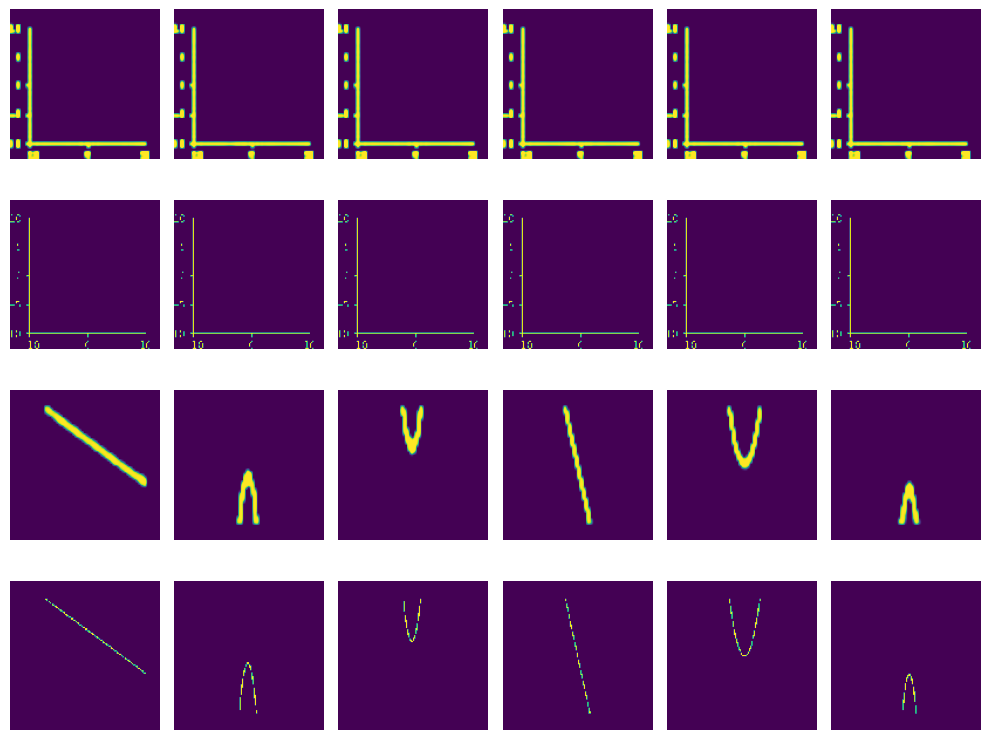

In [319]:
test_dataloader = create_dataloader(mode="test", num_samples=128, batch_size=32, shuffle=False, img_size=128)
test_step(DiceLoss(), test_dataloader)

# MaskPlot

fit with an overlaping line

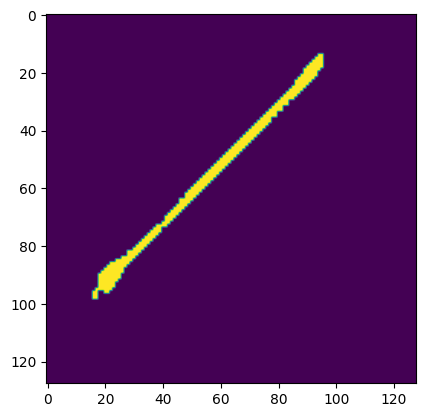

In [397]:
img, mask = next(iter(test_dataloader))
pred = model(img).detach().numpy()
selected = pred[0][1, :, :]
_, selected = cv2.threshold(selected, 0.9, 1, cv2.THRESH_BINARY)
plt.imshow(selected)

In [425]:
def lin_fn(x, a, b):
    return a * x + b

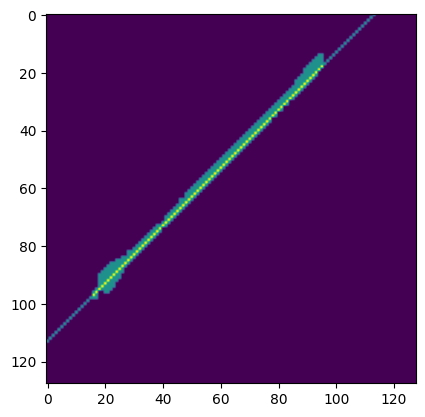

In [427]:
a, b = 1, 15
l_b, u_b = 0, 128

selected_c = selected.copy() * 0
for n in range(l_b, u_b):
    y_gen = lin_fn(n, a, b)
    bound = 128 - int(y_gen)
    if bound < l_b or bound > u_b:
        pass
    else:
        selected_c[n, bound] = 1

plt.imshow(selected_c + selected)

In [429]:
np.sum(selected * selected_c)

80.0

In [469]:
def fit(a, b):
    l_b, u_b = 0, 128
    tol = 2
    selected_c = selected.copy() * 0
    for n in range(l_b, u_b):
        y_gen = lin_fn(n, a, b)
        bound = 128 - int(y_gen)
        if bound < l_b or bound > u_b - 1:
            pass
        else:
            selected_c[n, bound] = 1
        for thick in range(tol):
            l_bound = 128 - int(y_gen) - thick
            u_bound = 128 - int(y_gen) + thick
            if l_bound < l_b or u_bound > u_b - 1:
                pass
            else:
                selected_c[n, l_bound] = 1
                selected_c[n, u_bound] = 1
    return np.sum(selected * selected_c)

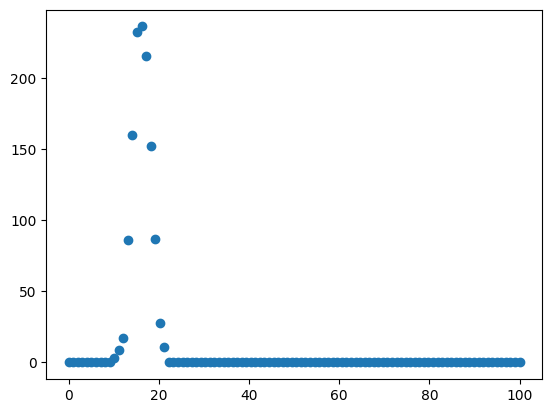

In [471]:
b = np.linspace(0, 100, 100)
iou = [fit(1, x) for x in b]
plt.plot(b, iou, "o")

resaling

In [42]:
img, mask = next(iter(test_dataloader))
mask = model(img).detach().numpy()
selected = mask[0][0, :, :]
#_, selected = cv2.threshold(selected, 0.9, 1, cv2.THRESH_BINARY)

Anchor is: (115, 17) with delta 98 that is scaled to 10
Each pixel is then scaled to 0.10204081632653061


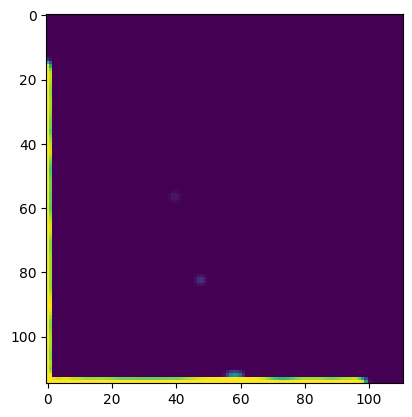

In [67]:
plt.imshow(selected[:115, 17:])
print(f"Anchor is: ({115}, {17}) with delta {115 - 17} that is scaled to {10}")
print(f"Each pixel is then scaled to {10/(115-17)}")

now lets draw a line accounting rescaling

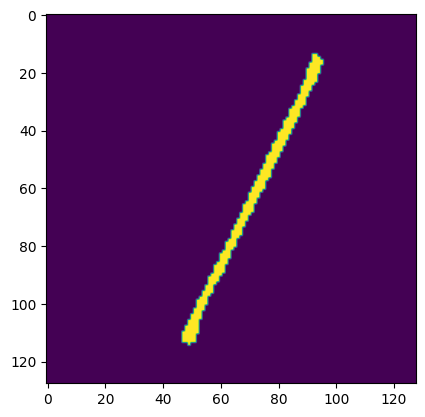

In [172]:
i = 0
for img, mask in test_dataloader:
     i += 1
     if i == 3:
        break
pred = model(img).detach().numpy()
selected = pred[0][1, :, :]
_, selected = cv2.threshold(selected, 0.9, 1, cv2.THRESH_BINARY)
plt.imshow(selected)

In [176]:
def lin_fn(x, a, b):
    a = a * 0.1
    b = b * 0.1
    return a * x + b

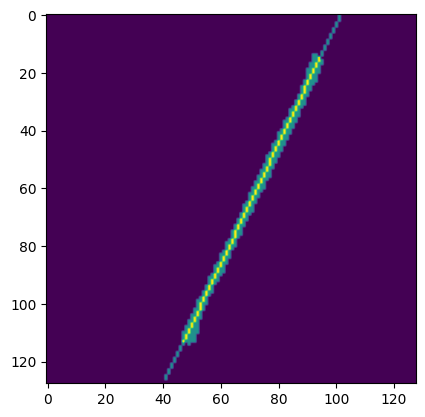

In [199]:
a, b = 4.8, 270
l_b, u_b = 0, 127

selected_c = selected.copy() * 0
for n in range(l_b, u_b):
    y_gen = lin_fn(n, a, b)
    bound = 128 - int(y_gen)
    if bound < l_b or bound > u_b:
        pass
    else:
        selected_c[n, bound] = 1

plt.imshow(selected_c + selected)

# PolinomialTest

(-10.0, 10.0)

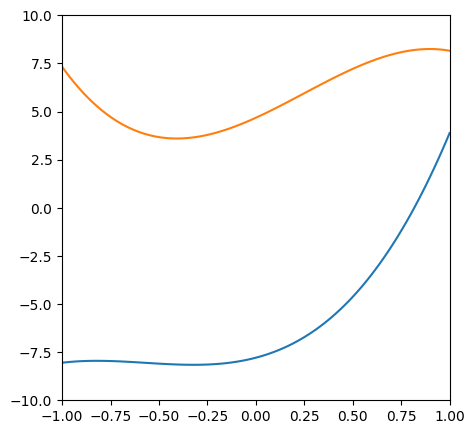

In [306]:
x = np.linspace(-1, 1, 100)

fig, ax = plt.subplots(figsize=(5, 5))

coefs = np.random.uniform(-10, 10, 4)
y = np.poly1d(coefs)
ax.plot(x, y(x))

coefs = np.random.uniform(-10, 10, 4)
y = np.poly1d(coefs)
ax.plot(x, y(x))

ax.set_xlim(-1, 1)
ax.set_ylim(-10, 10)

# Fit

In [9]:
from models_zoo.unet import UNet
from data.data import create_dataloader
from utils import load_model

In [ ]:
def rescale(dictx):
    rescaled = {}
    for key in dictx:
        new_key = (key - 66) / 24
        rescaled[new_key] = ((-1) * dictx[key] + 61) / 4
    return rescaled

In [50]:
model = UNet()
model = load_model(model, "intermediate.pth")

Models is loaded from:  intermediate.pth


In [51]:
test_dataloader = create_dataloader(mode="test", num_samples=128, batch_size=32, shuffle=False, img_size=128)

128


In [52]:
img, mask = next(iter(test_dataloader))
pred = model(img).detach().numpy()
selected = pred[0][1, :, :]

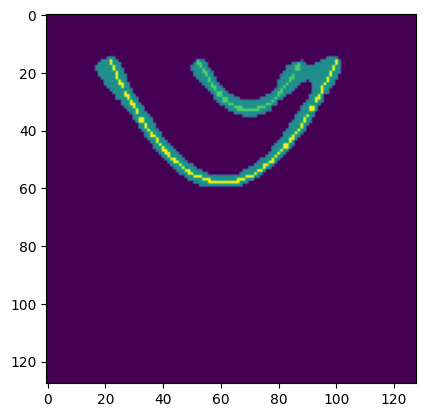

In [53]:
selected_c = selected.copy()
selected_c[selected_c < 1.8] = 0
plt.imshow(selected_c + mask[0][1].numpy())
plt.show()

In [ ]:
class FitExtract():

    def __init__(self) -> None:
        pass

    def rescale(self, dictx):
        rescaled = {}
        for key in dictx:
            new_key = (key - 66) / 24
            rescaled[new_key] = ((-1) * dictx[key] + 61) / 4
        return rescaled

    def find_plots(self, image):
        ty, tx = np.where(image != 0)
        t = zip(tx, ty)
        tx_set = set(tx)
        t_dict ={ti:[] for ti in tx_set}
        for x, y in t:
            t_dict[x].append(y)
        return t_dict

    def average(self, t_dict):
        t_mean = {ti:np.mean(t_dict[ti]) for ti in tx_set}
        return t_mean

    def extracted(self, t_dict):
        t_mean = self.average(t_dict)
        t_rescaled = self.rescale(t_mean)
        return t_rescaled

    def superposition(x, a11, a12, a13):
        y1 = np.poly1d([a11, a12, a13])
        return y1(x)

    def fit(self, t_rescaled):
        x_values = np.array(list(t_rescaled.keys()))
        y_values = np.array(list(t_rescaled.values()))
        bnds = [(-8, -8, -8, -8, -8, -8), (8, 8, 8, 8, 8, 8)]
        coefficients, _ = curve_fit(superposition, x_values, y_values, bounds=bnds)
        return coefficients
        

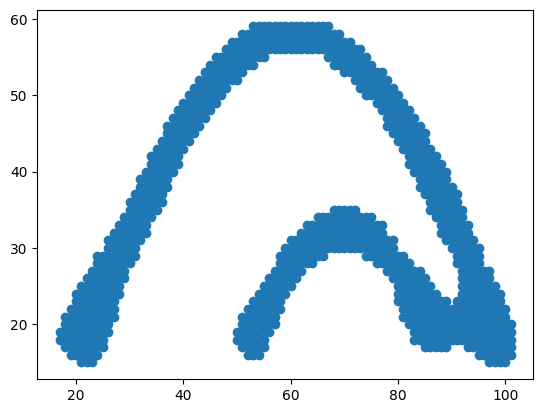

In [57]:
ty, tx = np.where(selected_c != 0)
plt.scatter(tx, ty)

In [58]:
t = zip(tx, ty)
tx_set = set(tx)
t_dict ={ti:[] for ti in tx_set}

for x, y in t:
    t_dict[x].append(y)

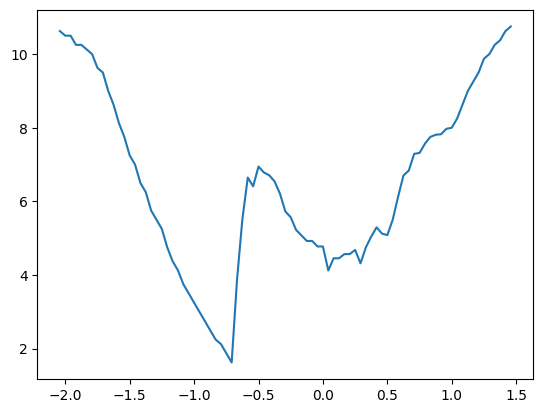

In [61]:
t_mean = {ti:np.mean(t_dict[ti]) for ti in tx_set}
t_mean = rescale(t_mean)
plt.plot(t_mean.keys(), t_mean.values())

In [62]:
from scipy.optimize import curve_fit

In [63]:
x_values = np.array(list(t_mean.keys()))
y_values = np.array(list(t_mean.values()))

def superposition(x, a11, a12, a13):
    y1 = np.poly1d([a11, a12, a13])
    return y1(x)

bnds = [(-8, -8, -8, -8, -8, -8), (8, 8, 8, 8, 8, 8)]
coefficients, _ = curve_fit(superposition, x_values, y_values, bounds=bnds)

In [64]:
coefficients

array([1.51873092, 1.15644339, 2.22022379, 0.73553076, 0.38920484,
       2.2069514 ])

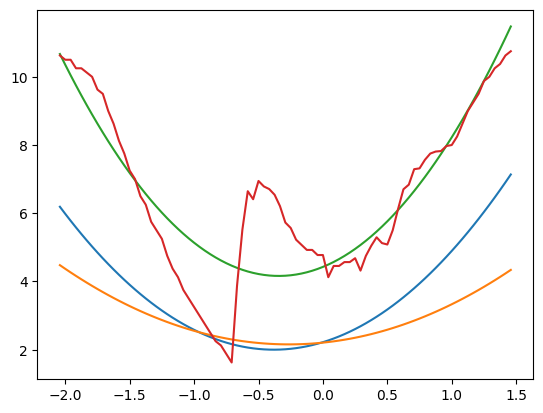

In [65]:
y1 = np.poly1d(coefficients[:3])
y2 = np.poly1d(coefficients[3:])

plt.plot(x_values, y1(x_values))
plt.plot(x_values, y2(x_values))
plt.plot(x_values, y1(x_values) + y2(x_values))
plt.plot(t_mean.keys(), t_mean.values())
plt.show()

In [28]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def superposition(x, a11, a12, a13, a21, a22, a23):
    y1 = np.poly1d([a11, a12, a13])
    y2 = np.poly1d([a21, a22, a23])
    return y1(x) + y2(x)

def objective(params, x, y):
    a11, a12, a13, a21, a22, a23 = params
    y_pred = superposition(x, a11, a12, a13, a21, a22, a23)
    return np.sum((y - y_pred) ** 2)

coef1 = [1, -2, 3, -4]
coef2 = [-1, 2, -3, 4]
poly_1 = np.poly1d(coef1)
poly_2 = np.poly1d(coef2)

In [29]:
initial_guess = [0, 0, 8, 0, 0, 1]

bounds = [(-8, 8)] * 6

result = minimize(objective, initial_guess, args=(x_values, y_values), bounds=bounds, method='L-BFGS-B')

optimized_params = result.x
a11, a12, a13, a21, a22, a23 = optimized_params

poly_1_fitted = np.poly1d([a11, a12, a13])
poly_2_fitted = np.poly1d([a21, a22, a23])

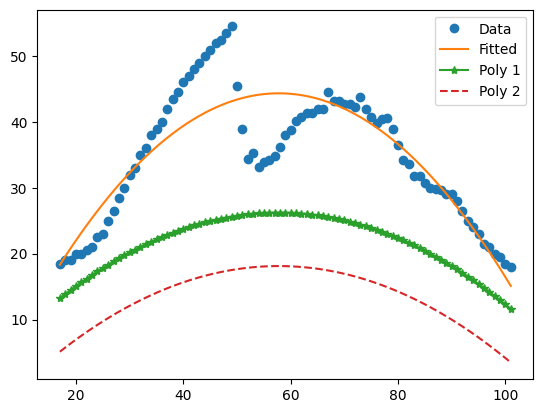

In [31]:
# Predict using the optimized parameters
y_pred_optimized = superposition(x_values, *optimized_params)
y_poly1 = poly_1_fitted(x_values)
y_poly2 = poly_2_fitted(x_values)

# Plot the results
plt.plot(x_values, y_values, 'o', label='Data')
plt.plot(x_values, y_pred_optimized, '-', label='Fitted')
plt.plot(x_values, y_poly1, '-*', label='Poly 1')
plt.plot(x_values, y_poly2, '--', label='Poly 2')
plt.legend()
plt.show()


# AxesMath

In [33]:
import torch.nn.functional as F

def within_tolerance(img, color, tol):
    return np.all(np.abs(img - np.array(color) * 255) <= tol, axis=-1)

def generate_img(coef):
    tolerance = 50
    # Generate random coefficients

    x = np.linspace(-2, 2, 100)

    # Create figure
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.set_xlim(-2, 2)
    ax.set_ylim(-10, 10)
    # Define colors
    axes_color = [0.0, 0.0, 0.0]

    coef = np.array(coef)
    y = np.poly1d(coef)
    line_color_1 = [0, 0, 1]
    ax.plot(x, y(x), color=line_color_1)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    fig.canvas.draw()
    image = np.array(fig.canvas.renderer.buffer_rgba())
    plt.close(fig)

    # Create masks
    image = image[:, :, :3]

    axes_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    plot_mask = np.zeros(image.shape[:2], dtype=np.uint8)

    # Mask axes
    axes_mask[within_tolerance(image, axes_color, tolerance)] = 1
    # Mask lines
    plot_mask[within_tolerance(image, line_color_1, tolerance)] = 1

    # Combine masks into a two-channel mask
    mask = np.stack((axes_mask, plot_mask), axis=0)

    # Convert to torch tensors
    image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
    mask = torch.from_numpy(mask).long()

    # Resize images and masks
    image = F.interpolate(image.unsqueeze(0), size=(128, 128), mode='bilinear', align_corners=False).squeeze(0)
    mask = F.interpolate(mask.unsqueeze(0).float(), size=(128, 128), mode='nearest').squeeze(0).long()

    return image, mask

img, mask = generate_img([1, 0, 1])

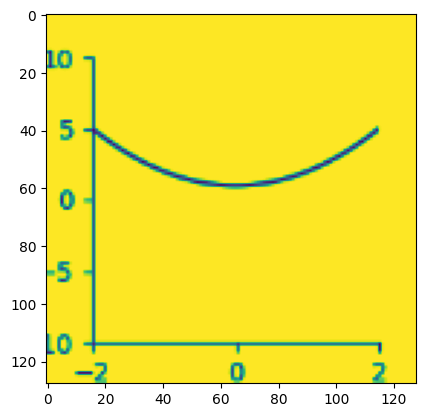

In [41]:
plt.imshow(img[0])

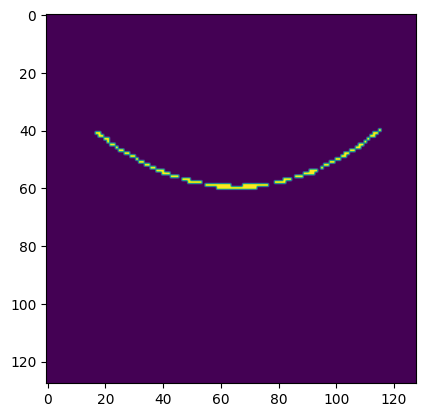

In [36]:
selected = mask[1]
plt.imshow(selected)

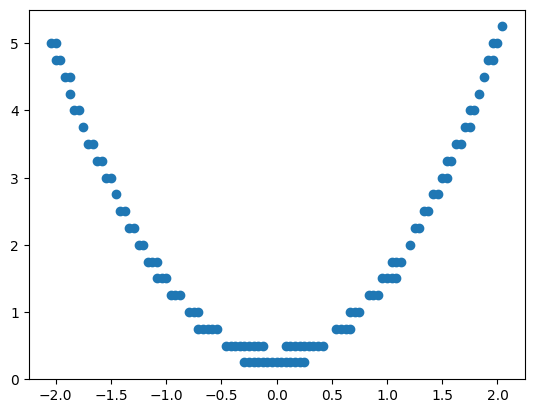

In [48]:
ty, tx = np.where(selected != 0)
tx = (tx - 66) / 24
ty = ((-1) * ty + 61) / 4
plt.scatter(tx, ty)